# Setup

### Install Concordia

In [4]:
!pip install concordia-harmony

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 18.0 MB/s eta 0:00:00


## Set up MuseScore for Colab

Click the play button below to install MuseScore to use in Google Colab

In [5]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:11 http://ppa.launchpad.net/mscore-ubuntu/mscore-stable/ubuntu focal InRelease [17.6 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,157 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:14 http://

In [6]:
!apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 26 not upgraded.
Need to get 7,697 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libfontenc1 amd64 1:1.1.4-0ubuntu1 [14.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libxfont2 amd64 1:2.0.3-1 [91.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libxkbfile1 amd64 1:1.1.0-1 [65.3 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/main amd64 x11-xkb-utils amd64 7.7+5 [158 kB]
Get:5 http://archive.ubuntu.com/ubunt

In [7]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

# music21 is Open Source under the BSD License
# Copyright (c) 2006-22 Michael Scott Asato Cuthbert and cuthbertLab
# Support music21 by citing it in your research or produts:
#
#     Cuthbert, Michael Scott.  
#     _music21: a Toolkit for Computer-Aided Music Research_
#     https://web.mit.edu/music21
#     2006-22

# Harmony Solving

## Demo

In [8]:
from concordia.constraints import *
from concordia.solver import ConcordiaSolver
from pprint import pprint

====== Model ======

====== Demo ======



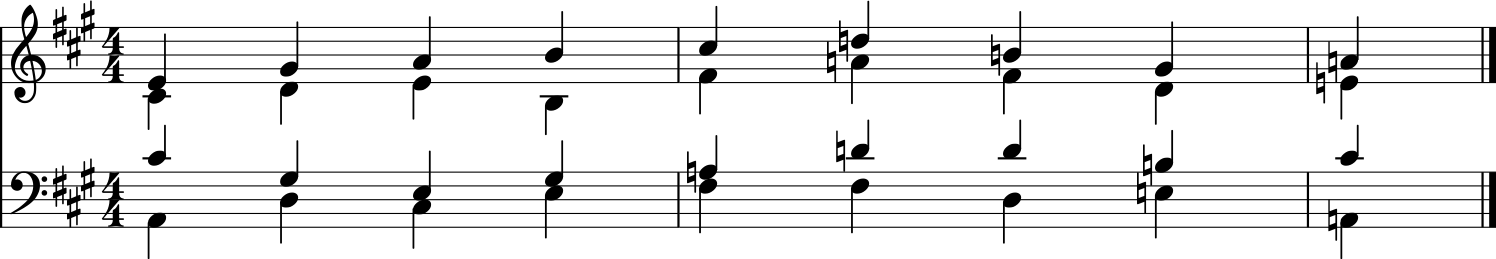

In [9]:
key = 'A'
romans = 'I IV4 I6 V vi IV6 ii6 V7 I'
num_chord = len(romans.split(' '))
chords = [ChordVar([f's{i}', f'a{i}', f't{i}', f'b{i}']) for i in range(num_chord)]
s, a, t, b = stream_vars = [StreamVar([f'{part}{i}' for i in range(num_chord)]) for part in ['s', 'a', 't', 'b']]

pitch_class_midi_rel = z3.And([PitchClassMidiRelation(pitch_var) for chord in chords for pitch_var in chord.pitches])
four_part_range = FourPartRange((s, a, t, b))
no_overlaps = z3.And([NoVoiceOverlap(chord_var) for chord_var in chords])
chord_eqs = z3.And([ChordEqRoman(chord_var, key, roman) for chord_var, roman in zip(chords, romans.split(' '))])

# More constraints
chord_specific = z3.And([DoubleRoot(chords[-1], key, 'I')])

no_crossing = z3.And([NoVoiceCrossing(a, b) for a, b in zip(chords, chords[1:])])
no_parallel_5th = z3.And([NoParallelFifth(a, b) for a, b in zip(chords, chords[1:])])
no_parallel_8ve = z3.And([NoParallelOctave(a, b) for a, b in zip(chords, chords[1:])])
smooth_voices = z3.And(SmoothVoice(s, 'M3'), SmoothVoice(a, 'P5'), SmoothVoice(t, 'P5'), SmoothVoice(b, 'P5'))
at_most_8ve_apart = z3.And(
    [VoicesWithinInterval(upper, lower, 'P8') for upper, lower in zip(stream_vars[:-1], stream_vars[1:-1])])

solver = ConcordiaSolver(key, stream_vars)
solver.add(pitch_class_midi_rel, four_part_range, no_overlaps, no_crossing, chord_eqs)
solver.add(chord_specific)
solver.add(no_parallel_5th)
solver.add(no_parallel_8ve)
solver.add(smooth_voices)
solver.add(PitchClassEq(chords[-1].soprano(), pitch.Pitch('A')))
# solver.add(PitchClassEq(chords[-2].soprano(), pitch.Pitch('G#')))
solver.add(at_most_8ve_apart)

solver.solve()

print('====== Model ======')
# pprint(solver.model)
print('\n====== Demo ======\n')
solver.display_results()
